# Exploratory data analysis of filtered dataset
In this notebook, we explore the filtered dataset of paired structures

In [3]:
import sys
sys.path.extend(["../code/src"])

import pandas as pd
import numpy as np
from pathlib import Path

from collections import Counter, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils.fasta import parse_fasta, write_fasta

In [2]:
out_path = Path("filtered_eda")
out_path.mkdir(exist_ok=True)

In [10]:
filtered_df = pd.read_csv("../../data/processed/pdb_pairs/filtered_df.csv")

# Exploration

## Types of phosphosite

In [7]:
uniprot_ids = list(filtered_df["UNIPROT"])
phospho_aa = list(filtered_df["CHEM_COMP_TWO"])
nonphospho_aa = list(filtered_df["CHEM_COMP_ONE"])
res_idx = list(filtered_df["UNIPROT_RESIDUE_NUMBER"])

unique_sites = set(list(zip(uniprot_ids, phospho_aa, nonphospho_aa, res_idx)))
unique_phospho_aas = [aa[1] for aa in unique_sites]
unique_nonphospho_aas = [aa[2] for aa in unique_sites]
phospho_aa_counts = Counter(unique_phospho_aas)
nonphospho_aa_counts = Counter(unique_nonphospho_aas)

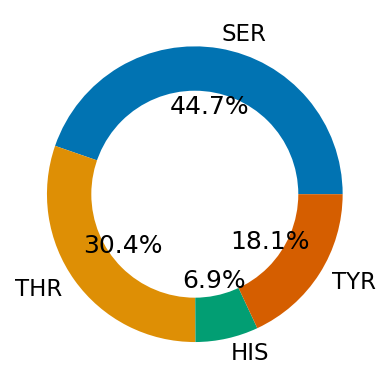

In [16]:
# Phosphosites
sns.set_context('talk')
labels = list(nonphospho_aa_counts.keys())
values = np.array(list(nonphospho_aa_counts.values()))

aa_palette = sns.color_palette("colorblind", 4)

fig1, ax1 = plt.subplots()
plt.pie(values,labels=labels,autopct='%1.1f%%',colors=aa_palette)
#ax1.axis('equal')

fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.savefig(str(out_path / 'filtered_phosphosites_by_residue_donut.pdf'), bbox_inches='tight',dpi=150)

## How many pairs of structures per unique protein?

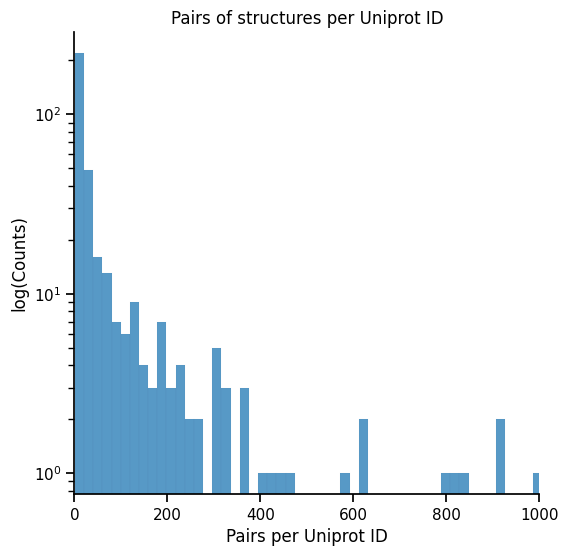

In [17]:
uniprot_id_counter = list(Counter(list(df['UNIPROT'])).values())
plt.figure(figsize=(6,6))
sns.set_context('notebook')
ax = sns.histplot(uniprot_id_counter,kde=False,color="tab:blue")
sns.despine()
ax.set_yscale('log')
ax.set_xlabel("Pairs per Uniprot ID")
ax.set_ylabel("log(Counts)")
ax.set_title("Pairs of structures per Uniprot ID")

ax.set_xlim(0,1000)

plt.savefig(str(out_path / "histogram_uniprot_id_appearances.png"),dpi=150, bbox_inches='tight')

## How many phosphosites per Uniprot ID?

In [18]:
unique_prots = list(filtered_df["UNIPROT"].unique())
uniprot_to_unique_psites = {}
for uniprot_id in unique_prots:
    subset_df = filtered_df.loc[filtered_df["UNIPROT"]==uniprot_id]
    unique_residues = subset_df["UNIPROT_RESIDUE_NUMBER"].unique()
    uniprot_to_unique_psites[uniprot_id] = len(unique_residues)
    

uniprot_to_unique_psites = sorted(uniprot_to_unique_psites.items(), key=lambda x:x[1], reverse=True)
uniprot_to_unique_psites = dict(uniprot_to_unique_psites)


In [19]:
ax = sns.histplot(list(uniprot_to_unique_psites.values()))
ax.set_yscale('log')

ax.set_xlabel('Number of unique phosphosites per Uniprot ID')

sns.despine()
plt.savefig(str(out_path / "histogram_uniprot_id_psites.png"),dpi=150, bbox_inches='tight')

In [20]:
uniprot_df = pd.read_csv(input_path /"uniprot"/ "uniprot_data.tsv",delimiter='\t')
uniprot_df = uniprot_df.loc[uniprot_df["Entry"].isin(unique_prots)]

In [21]:
species_counter = Counter(uniprot_df['Organism'].values.tolist())

print(f"How many different species? {len(set(species_counter.keys()))}")
sns.set_context("notebook")
plt.figure(figsize=(6,6))
ax = sns.histplot(list(species_counter.values()),kde=False,color='tab:green')
ax.set_ylabel("Counts")
ax.set_xlabel("UniProt IDs per species")
sns.despine()

plt.savefig(str(out_path / "species_hist.png"),bbox_inches='tight',dpi=150)

How many different species? 58


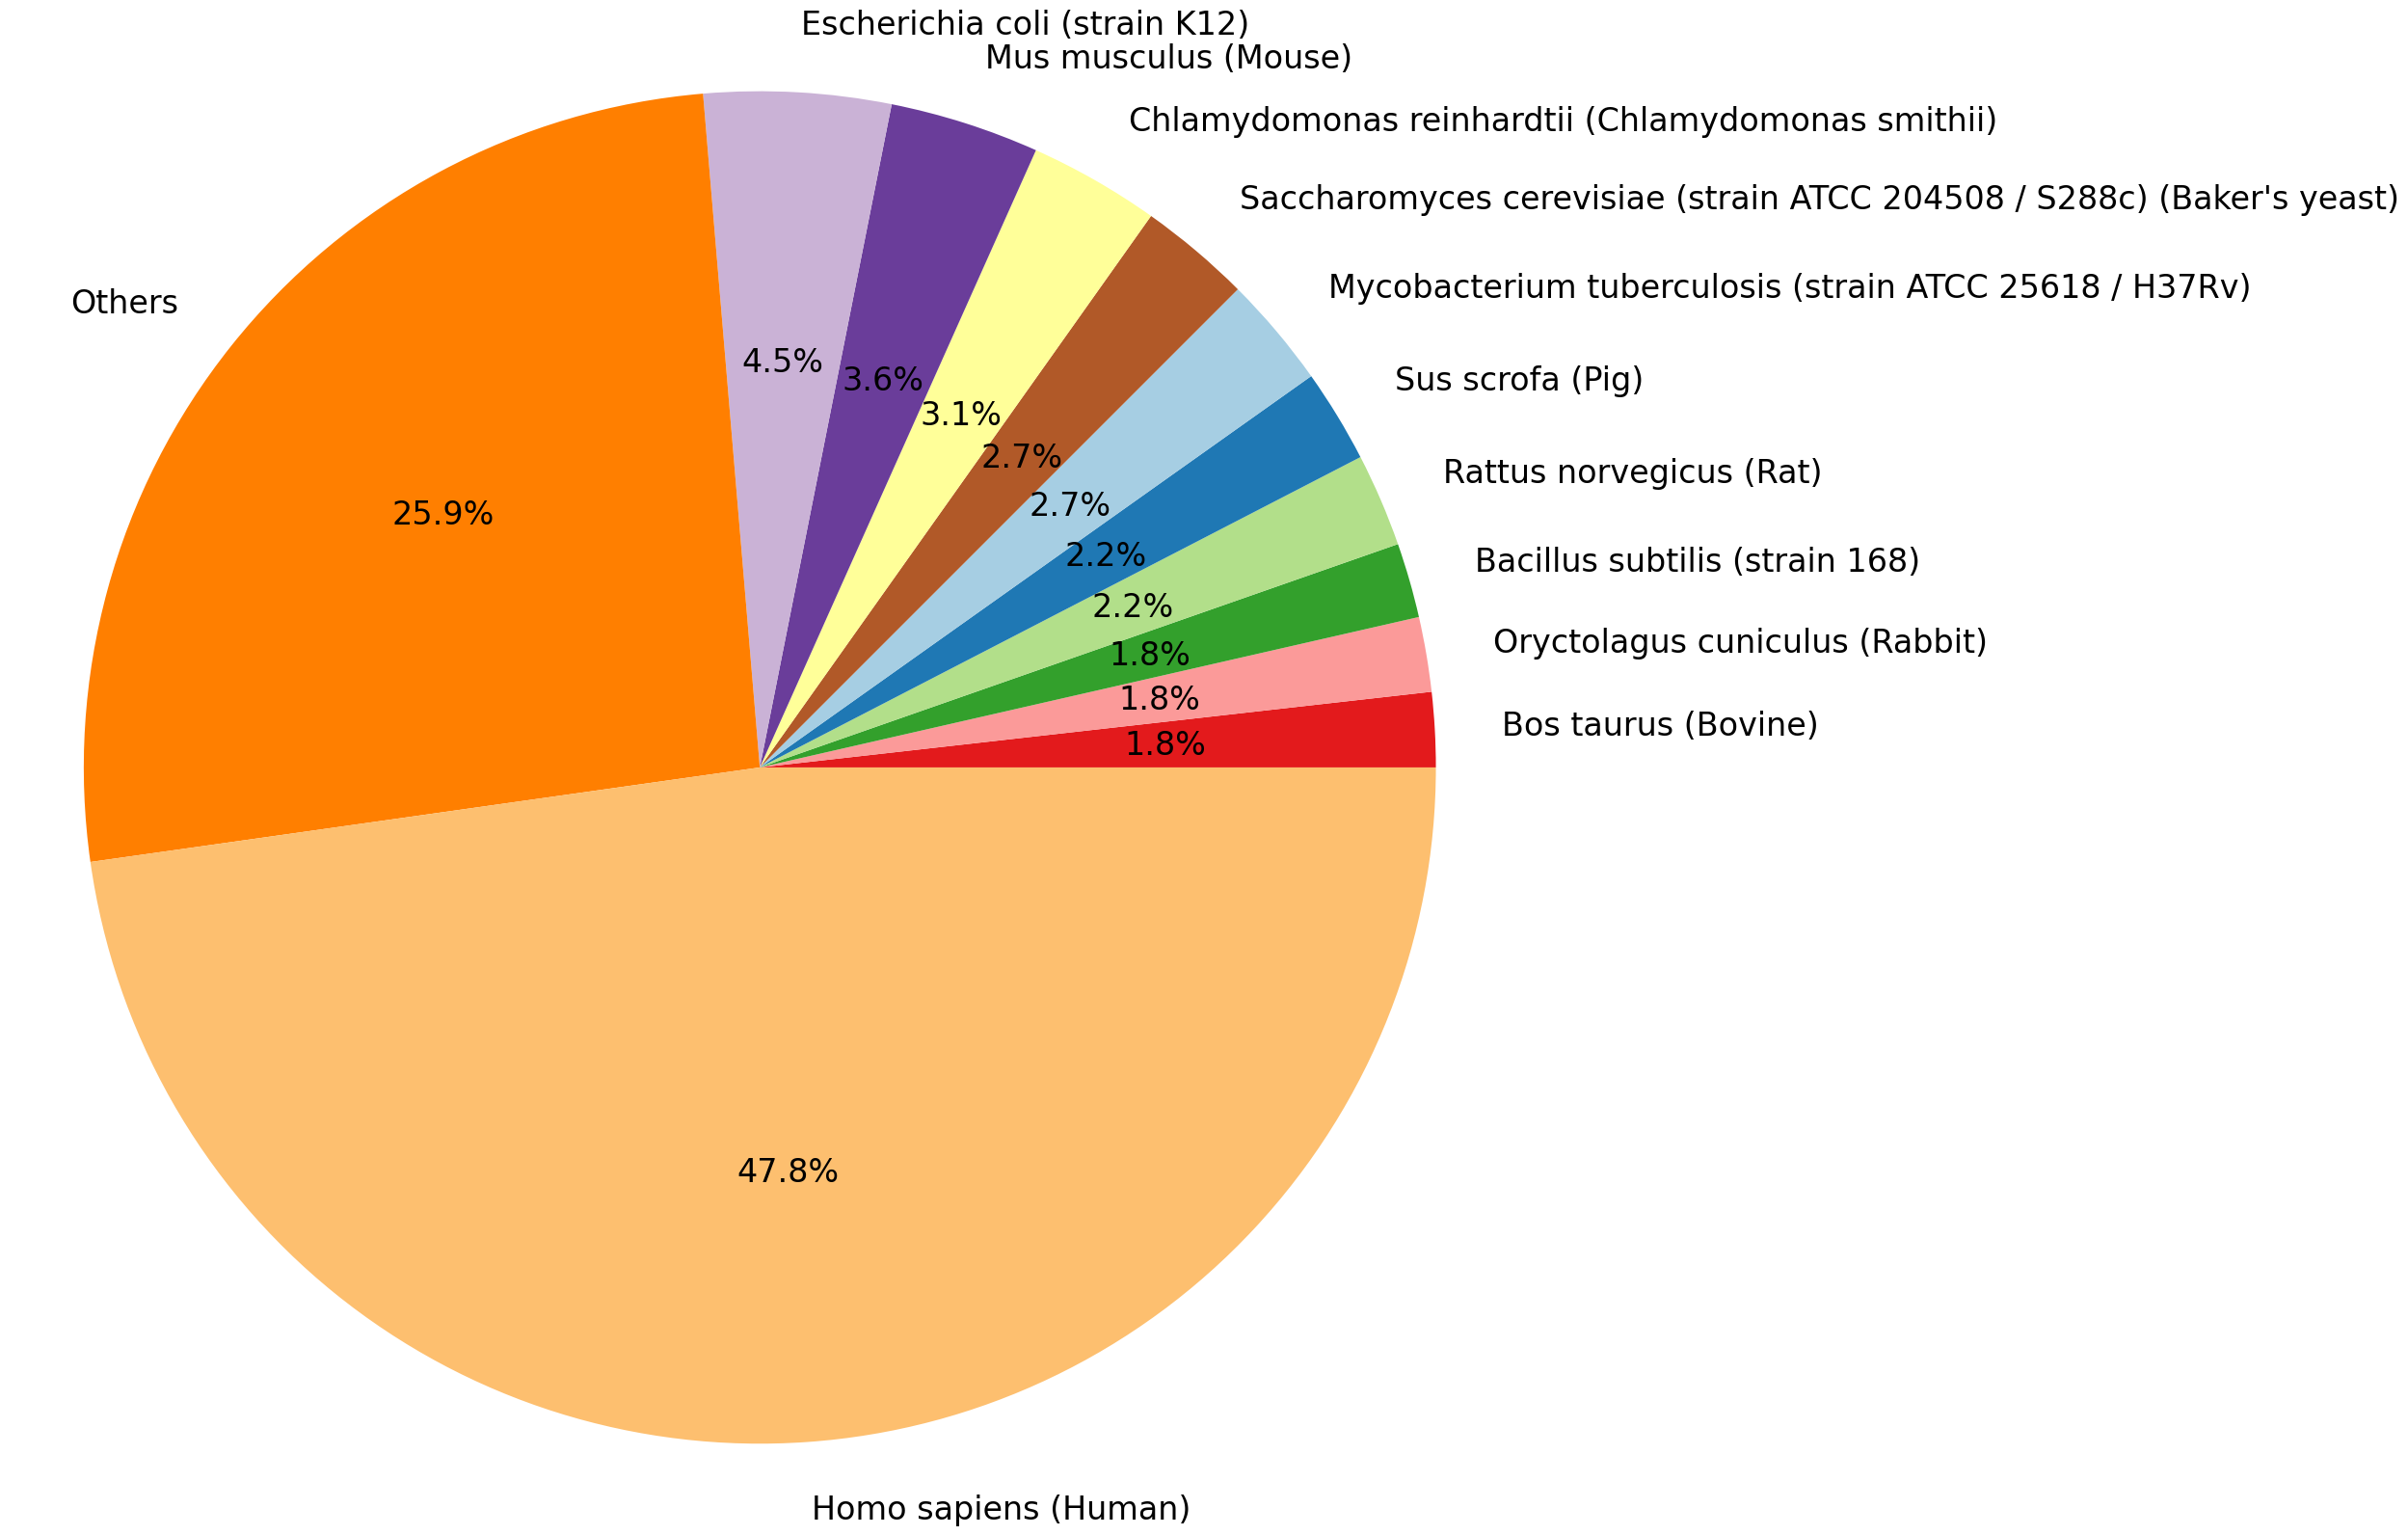

In [22]:
species_counter_shortened = defaultdict(int)
for k, v in species_counter.items():
    if v>3:
        species_counter_shortened[k] = v
    else:
        species_counter_shortened["Others"] += v

species_counter_shortened = {k: v for k, v in sorted(species_counter_shortened.items(), key=lambda item: item[1])}
        
sns.set_context("paper")
species_labels = list(species_counter_shortened.keys())
species_values = list(species_counter_shortened.values())

fig1, ax1 = plt.subplots(figsize=(20,20))
species_palette = sns.color_palette("Paired",18)[::-1]
ax1.pie(species_values,labels=species_labels,colors=species_palette, autopct='%1.1f%%',textprops={'fontsize': 24})
ax1.axis('equal')

plt.savefig(str(out_path/"filtered_species_pie.png"),bbox_inches='tight',dpi=200)

In [23]:
# Quick hack to get unique phosphosites
rmsd_summary_df = pd.read_csv("backbone_comparison/rmsd_merged_df.csv")
rmsd_summary_df_nodups = rmsd_summary_df.drop_duplicates(subset=list(rmsd_summary_df.columns)[3:])
unique_psites = rmsd_summary_df_nodups["phosphosite"]

In [24]:
filtered_df["PHOSPHOSITE"]

0         P24941_160
1         P24941_160
2         P24941_160
3         P24941_160
4         P28482_187
             ...    
186896    P63086_183
186898    P25321_140
186899    P25321_140
186900    P24941_160
186901    P24941_160
Name: PHOSPHOSITE, Length: 135122, dtype: object

In [25]:

columns = ["phosphorylated","non-phosphorylated"]
structures_per_psite_df = []

for unique_psite in unique_psites:
    subset_df = filtered_df.loc[df["PHOSPHOSITE"]==unique_psite]
    np_set = subset_df["ENTRY_ID_ONE"].unique()
    p_set = subset_df["ENTRY_ID_TWO"].unique()
    
    structures_per_psite_df.append([len(p_set), len(np_set)]) 
    
structures_per_psite_df = pd.DataFrame(structures_per_psite_df,columns=columns)

In [43]:
structures_per_psite_df_subset

phosphorylated  non-phosphorylated
0                 1                   1
1                 1                   7
3                 1                   7
4                 1                   2
5                 1                   7
..              ...                 ...
289               1                   6
290               1                   1
292               1                   2
293               2                   1
295               1                   1

[180 rows x 2 columns]

In [46]:
structures_per_psite_df_subset = structures_per_psite_df.loc[(structures_per_psite_df["phosphorylated"]<10) & (structures_per_psite_df["non-phosphorylated"]<10)]

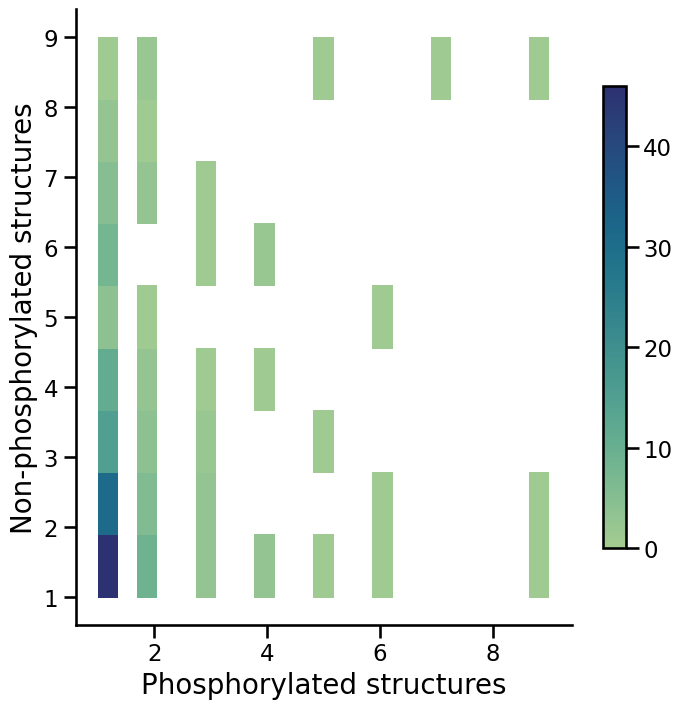

In [51]:
sns.set_context("talk")
plt.figure(figsize=(8,8))

g = sns.histplot(data=structures_per_psite_df_subset,x="phosphorylated",y="non-phosphorylated",
                 log_scale=(False,False),cbar=True, cbar_kws=dict(shrink=.75),cmap='crest')
sns.despine()
plt.xlabel("Phosphorylated structures",fontsize=20)
plt.ylabel("Non-phosphorylated structures",fontsize=20)
plt.savefig(out_path / "structures_per_psite_filtered_subset.pdf",dpi=120,bbox_inches='tight')

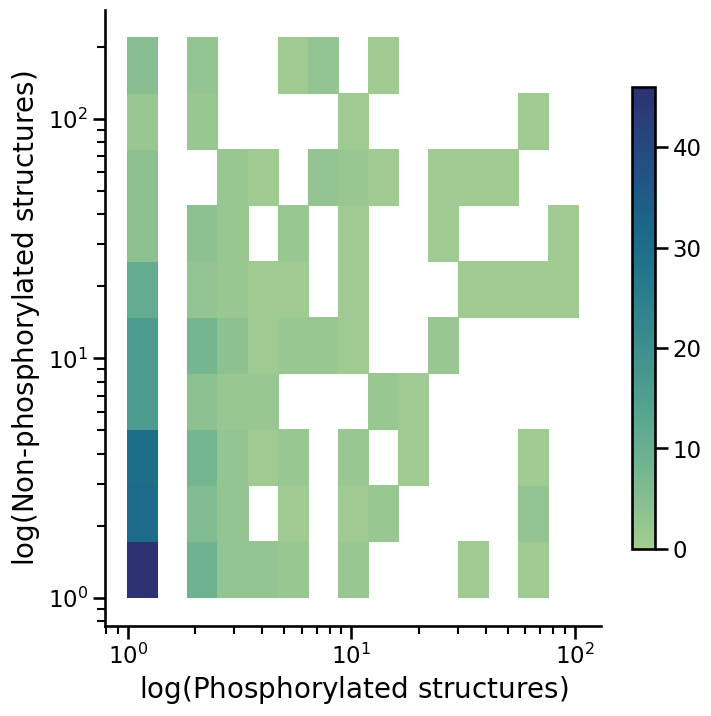

In [26]:
sns.set_context("talk")
plt.figure(figsize=(8,8))

g = sns.histplot(data=structures_per_psite_df,x="phosphorylated",y="non-phosphorylated",
                 log_scale=(True,True),cbar=True, cbar_kws=dict(shrink=.75),cmap='crest')
sns.despine()
plt.xlabel("$\log$(Phosphorylated structures)",fontsize=20)
plt.ylabel("$\log$(Non-phosphorylated structures)",fontsize=20)
plt.savefig(out_path / "structures_per_psite_filtered.pdf",dpi=120,bbox_inches='tight')

In [27]:
quality_df = pd.read_csv("../data/raw/pdb_pairs/quality_df.csv")

In [28]:
quality_df

pdb_id             method  resolution    rfree
0      6QY7  X-ray diffraction        2.10  0.23538
1      1EUD  X-ray diffraction        2.10  0.21500
2      4DH8  X-ray diffraction        2.30  0.18800
3      6QZ1  X-ray diffraction        1.70  0.19180
4      8P04  X-ray diffraction        2.60  0.25880
...     ...                ...         ...      ...
7803   1JLU  X-ray diffraction        2.25      NaN
7804   1NSQ  X-ray diffraction        2.18      NaN
7805   721P  X-ray diffraction        2.00      NaN
7806   1OGW  X-ray diffraction        1.32      NaN
7807   1ALJ  X-ray diffraction        2.60      NaN

[7808 rows x 4 columns]

In [29]:
pdbs_one = list(filtered_df["ENTRY_ID_ONE"].unique())
pdbs_two = list(filtered_df["ENTRY_ID_TWO"].unique())

pdb_ids = list(set(pdbs_one).union(set(pdbs_two)))
pdb_ids = [x.upper() for x in pdb_ids]

In [30]:
filtered_quality_df = quality_df.loc[quality_df["pdb_id"].isin(pdb_ids)]

In [31]:
counter = Counter(filtered_quality_df["method"])

In [32]:
# Counter({'X-ray diffraction': 4664,
#          'Solution NMR': 87,
#          'Electron Microscopy': 50,
#          'Solid-state NMR': 2})
# Just put together solution and solid-state ones, not enough of the latter to have their own category
counter["NMR (solution & solid-state)"] = counter["Solution NMR"] + counter["Solid-state NMR"]
del counter["Solution NMR"]
del counter["Solid-state NMR"]

In [33]:
counter

Counter({'X-ray diffraction': 4664,
         'NMR (solution & solid-state)': 89,
         'Electron Microscopy': 50})

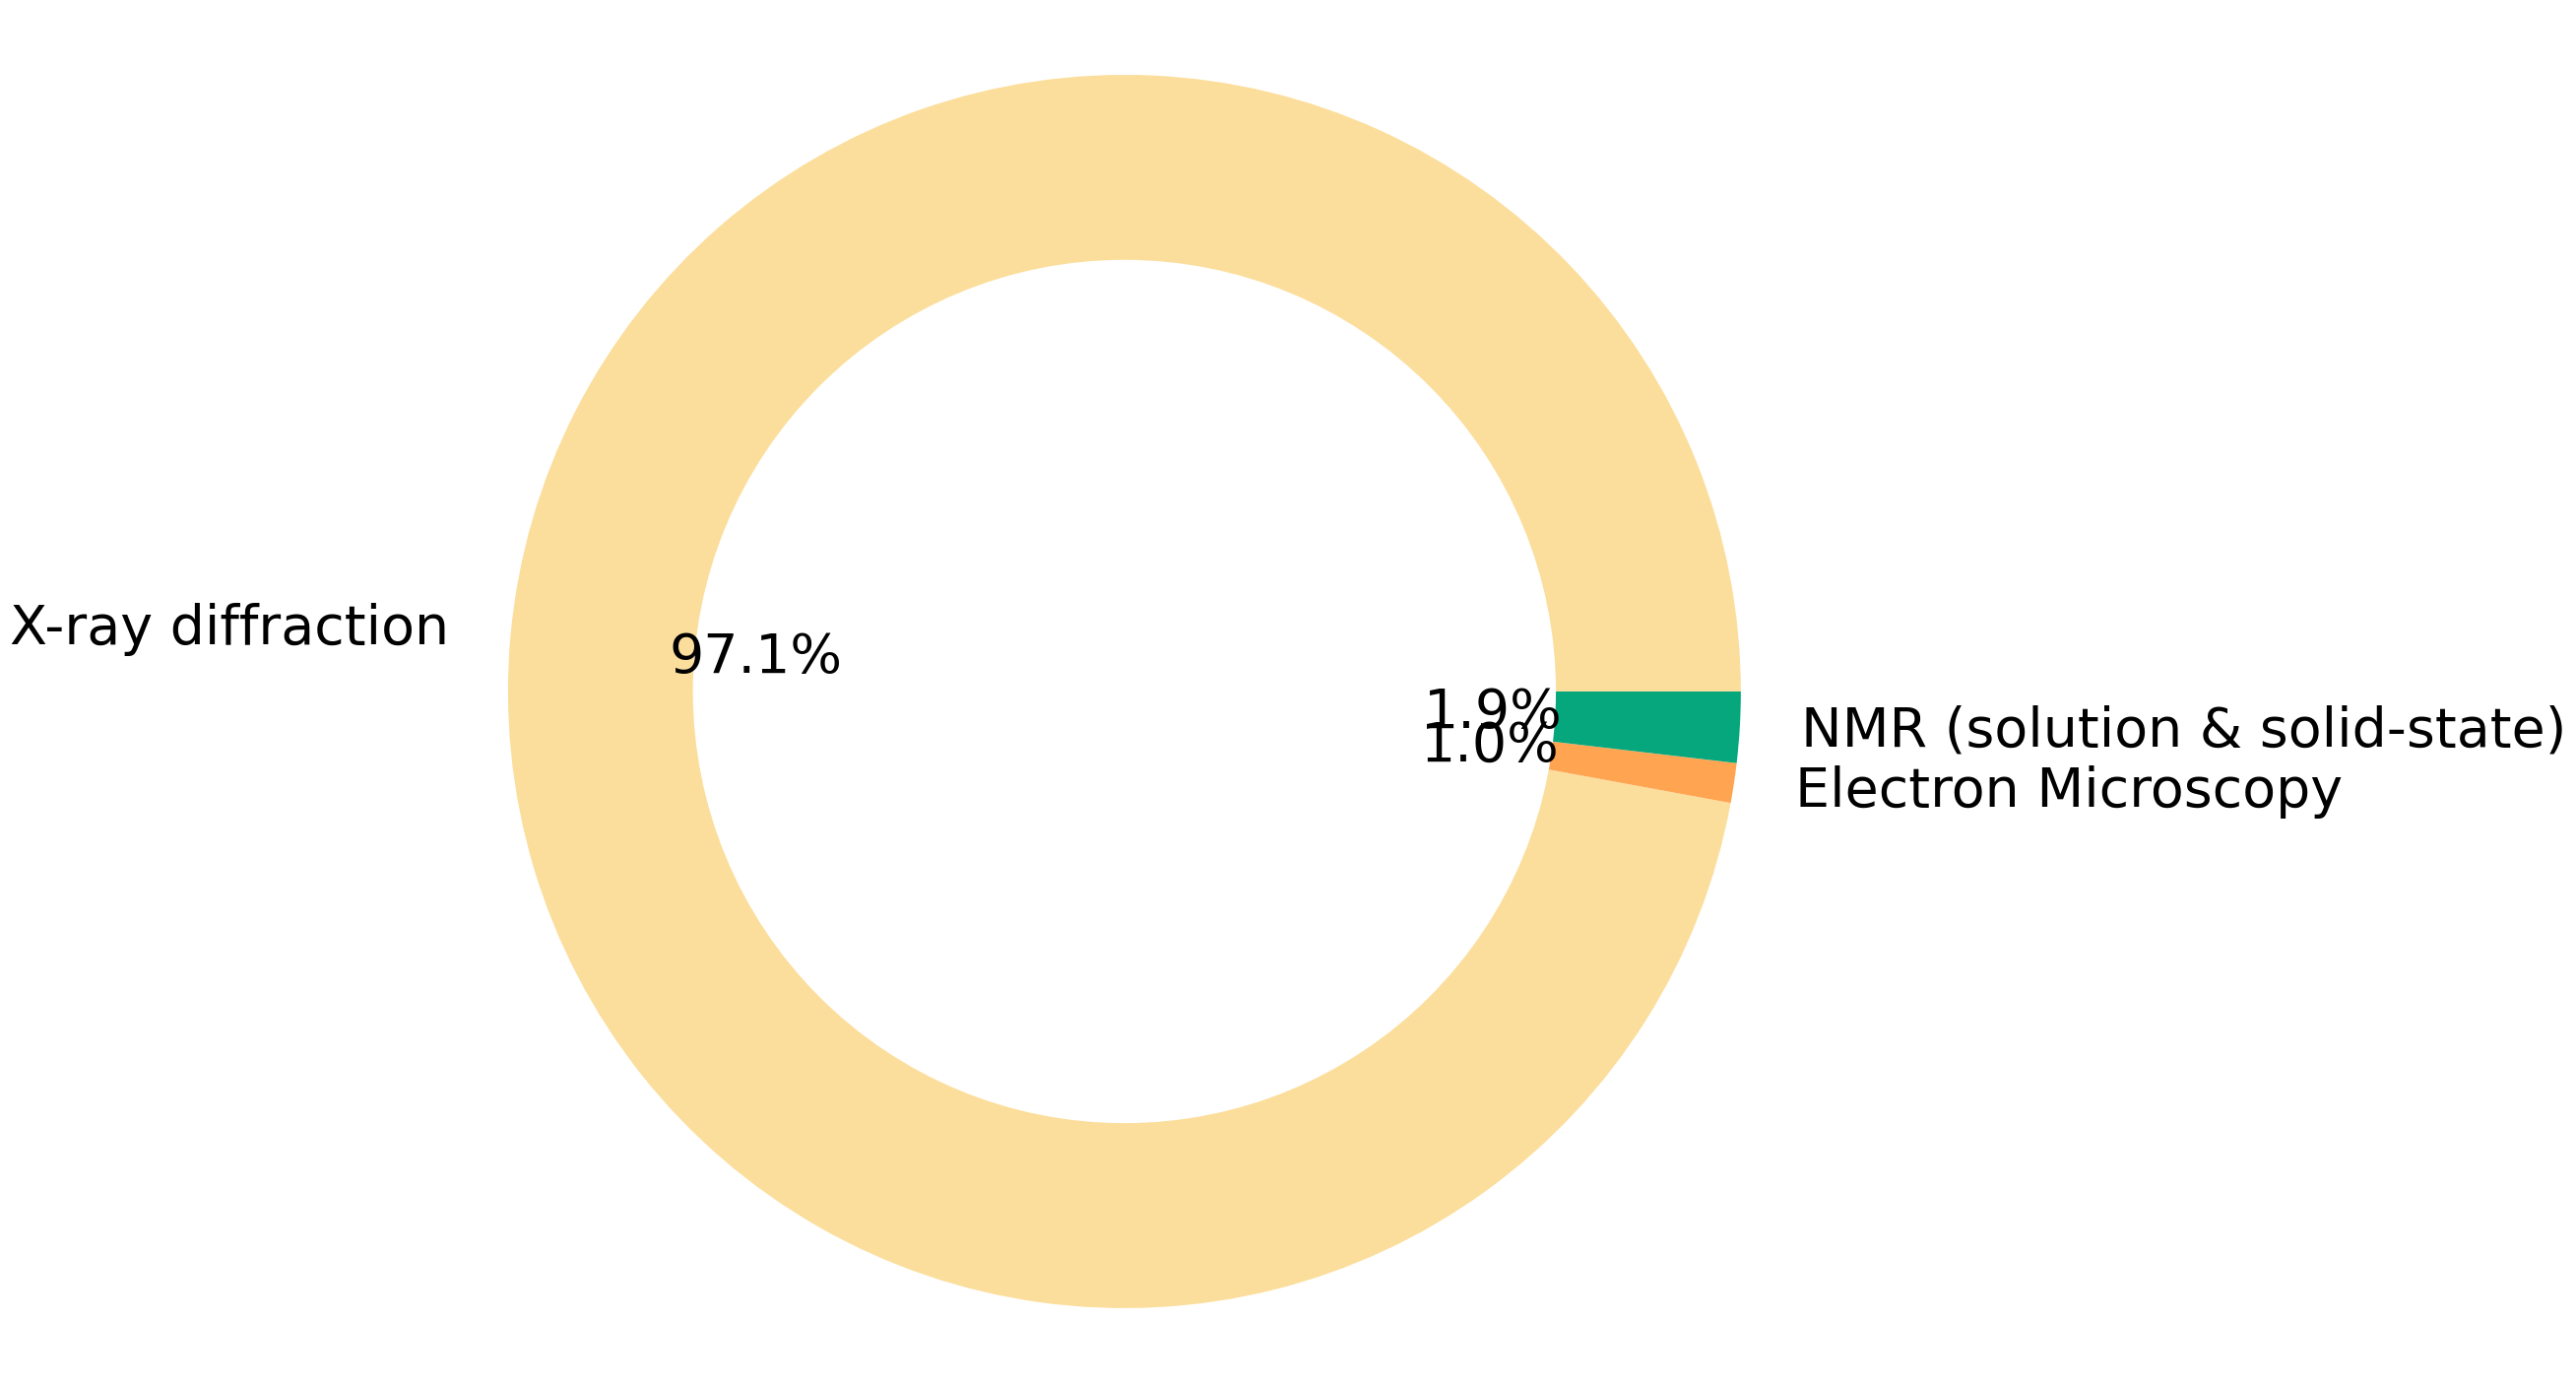

In [34]:
sns.set_context("talk")
method_labels = list(counter.keys())
method_values = list(counter.values())

fig1, ax1 = plt.subplots(figsize=(22,18))
#methods_palette = sns.color_palette("Paired",18)[::-1]
colors = ["#FCDE9C","#FFA552","#06A77D","#D5C67A"]
plt.pie(method_values,labels=method_labels,colors=colors, 
         autopct='%1.1f%%',textprops={'fontsize': 40})

plt.axis('equal')

fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)


plt.savefig(str(out_path/"filtered_methods_donut.pdf"),bbox_inches='tight',dpi=200)